In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import os
home_dir = os.environ['HOME'] + '/'
import pyCloudy as pc
print(pc.__version__)

0.9.9


In [2]:
# Changing the location and version of the cloudy executable.
pc.config.cloudy_exe = '/Users/caridlin/Documents/Cloudy17.01/source/cloudy.exe'

In [3]:
dir_ = '/Users/caridlin/Documents/Cloudy17.01/pyCloudy/Simple_3D_rotation_debug4/'
pc.print_make_file(dir_)

# Disk Galaxy Density Profile

## Sersic Disk Profile 

In [4]:
from scipy.special import kn, iv

def Sersic_profile(A, R, n, r):
    return A * np.exp(- (2 * n - 0.324) * ((r / R) ** (1 / n) - 1)) 

def Sersic_profile_disk(A, R, zd, n, r, z):
    return A / (4 * zd) * np.exp(- (2 * n - 0.324) * ((r / R) ** (1 / n) - 1)) / np.cosh(z / (2 * zd)) ** 2

def Radial_velocity_star(Re, sigma_0, r):
    Rd = Re / 1.67
    y = r / (2 * Rd)
    return 0.007352 * np.sqrt(sigma_0 * Rd * y ** 2 * (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y)))

def Radial_velocity(c, V, Rvir, Re, sigma_0, r):
    return np.sqrt(Radial_velocity_halo(c, V, Rvir, r) ** 2 + Radial_velocity_star(Re, sigma_0, r) ** 2)

## Some Parameters

In [5]:
A = 1.03696e7   # In units of solar mass/kpc^2
Re = 25.303606  # Effective radius
n = 1.6844      # Sersic index
B = 1.515186    # thickness of the disk
print(Radial_velocity_star(Re, A, 50))

# fig, ax = plt.subplots(figsize = (6, 4))
# x, y, z = np.meshgrid(np.arange(-100, 100, 1),
#                    np.arange(-100, 100, 1), 
#                 np.arange(-10, 10, 0.1))

# print(Sersic_profile(A, Re, n, 50)/(4*B))
# print(Sersic_profile_disk(A, Re, B, n, 50, 0))

# rho = Sersic_profile_disk(A, Re, B, n, np.sqrt(x ** 2 + (y / q) ** 2), z)
# im = ax.pcolormesh(x[:, :, 0], y[:, :, 0], np.sum(rho, axis = 2),  cmap='RdBu')

# ax.minorticks_on()
# ax.tick_params(axis = 'both', which = 'minor', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
#                grid_color='black', grid_alpha=0.5)
# ax.tick_params(axis = 'both', which = 'major', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
#                grid_color='black', grid_alpha=0.5)


# ax.set_xlabel('kpc')
# ax.set_ylabel('kpc')

# ax.set_aspect('equal')
# plt.colorbar(im)

# # Chech normalization factor
# print(np.sum(rho) * 1 * 1 * 0.1 / q  * 1e-11)

38.07921727270947


# CLOUDY Model

In [6]:
def set_models(dir_, model_name):
    emis_tab = ['H  1  4861.33A',
            'H  1  6562.81A',
            'Ca B  5875.64A',
            'N  2  6583.45A',
            'O  1  6300.30A',
            'O  2  3726.03A',
            'O  2  3728.81A',
            'O  3  5006.84A',
            'BLND  4363.00A'
            ]
    emis_tab_c13 = ['H  1  4861',
                'H  1  6563',
                'He 1  5876',
                'N  2  6584',
                'O  1  6300',
                'O II  3726',
                'O II  3729',
                'O  3  5007',
                'TOTL  4363',
                'O  1 63.17m',
                'O  1 145.5m',
                'C  2 157.6m',
                'H  1 4.051m']      
    #phis = np.linspace(0., 360., 25)
    thetas = np.linspace(0., 90., 7)
    # Radius in units of log cm
    # r1 (in kpc), rs_in (in log cm): inner radius, r2, rs_out: outer radius
    r1 = 0.3
    rs_in = np.log(r1 * 3.086e21) / np.log(10)
    r2 = 60
    rs_out = np.log(r2 * 3.086e21) / np.log(10)
    radius = np.linspace(r1 - 0.1, r2 + 10, 51)
    
    model = pc.CloudyInput()
    model.set_grains()
    model.set_emis_tab(emis_tab)
    
    #for phi in phis:
    for theta in thetas:
        # Need to reset model.set_other first, otherwise will append the list
        model.set_other()
        # Write the dlaw table
        # r_ are in units of kpc, while Sersic_profile_disk are in units of solar mass/kpc^3
        # should convert to r_ log 10 of cm, and density log 10 of cm^-3
        table = 'table HM12 z=0.435\n'
        table = table + 'cmb z=0.435\n'
        table = table + 'luminosity 43.0177 range 0.5478 to 0.6535 Ryd\n'
        table = table + 'table SED "SFGSED.SED" extrapolate\n'
        table = table + 'dlaw table radius\n'

        index = 0
        for r_ in radius:
            #temp = np.log(Sersic_profile_disk(A, Re, B, n, np.sqrt((r_ * np.cos(np.pi / 180. * theta) * np.cos(np.pi / 180. * phi)) ** 2 + (r_ * np.cos(np.pi / 180. * theta) * np.sin(np.pi / 180. * phi) / q) ** 2), r_ * abs(np.sin(np.pi / 180. * theta))) * 2.001e-10) / np.log(10)
            temp = np.log(Sersic_profile_disk(A, Re, B, n, r_, r_ * abs(np.sin(np.pi / 180. * theta))) * 2.001e-10) / np.log(10)
            if temp >= -10:
                table = table + 'continue %.9f %.9f \n' % (np.log(r_ * 3.086e21) / np.log(10), temp)
                index = index + 1
            else:
                rs_out = np.log(r_ * 3.086e21) / np.log(10)
                break

        for r_ in radius[index : index + 20]:
            #temp = np.log(Sersic_profile_disk(A, Re, B, n, np.sqrt((r_ * np.cos(np.pi / 180. * theta) * np.cos(np.pi / 180. * phi)) ** 2 + (r_ * np.cos(np.pi / 180. * theta) * np.sin(np.pi / 180. * phi) / q) ** 2), r_ * abs(np.sin(np.pi / 180. * theta))) * 2.001e-10) / np.log(10)
            temp = np.log(Sersic_profile_disk(A, Re, B, n, r_, r_ * abs(np.sin(np.pi / 180. * theta))) * 2.001e-10) / np.log(10)
            table = table + 'continue %.9f %.9f \n' % (np.log(r_ * 3.086e21) / np.log(10), temp)

        table = table + 'end of dlaw\n'
        table = table + 'abundances GASS no grains\n'
        table = table + 'radius %.4f %.4f\n' % (rs_in, rs_out)
        table = table + 'no induced processes\n'
        table = table + 'iterate to convergence\n'
        options = (table)
        model.set_other(options)
        #model.model_name = '{0}/{1}_{2:.0f}_{3:.0f}'.format(dir_, model_name, theta, phi)
        model.model_name = '{0}/{1}_{2:.0f}'.format(dir_, model_name, theta)
        #model.set_theta_phi(theta, phi)
        model.set_theta_phi(theta)
        model.print_input(to_file = True, verbose = False)

In [11]:
# model_name = "M3D_1"
# pc.log_.calling = 'Model3D : ' + model_name
# pc.log_.level = 3

# dim = 101
# n_cut = int((dim-1) /2)

# set_models(dir_, model_name)

In [77]:
pc.print_make_file(dir_ = dir_)
pc.run_cloudy(dir_ = dir_, n_proc = 6, model_name = model_name, use_make = True)

     run_cloudy: running: cd /Users/caridlin/Documents/Cloudy17.01/pyCloudy/Simple_3D_rotation_debug4/ ; make -j 6 name="M3D_1"
     run_cloudy: ending: cd /Users/caridlin/Documents/Cloudy17.01/pyCloudy/Simple_3D_rotation_debug4/ ; make -j 6 name="M3D_1"


In [9]:
# liste_of_models = pc.load_models('{0}/{1}'.format(dir_, model_name), list_elem=['H', 'He', 'C', 'N', 'O', 'Ar', 'Ne'],  
#                                            read_cont = False, read_grains = False)

In [10]:
# Print the models that are wrong
[(M.model_name, M.out['wrong']) for M in liste_of_models if 'wrong' in M.out]

[]

# Velocity Model

## Circular Velocity For a NFW Halo

In [12]:
def VirialR(Mh, H):
    return 0.3504 * (Mh / (H**2))**(1/3)

def VirialV(Mh, R):
    return 0.002074 * np.sqrt(Mh / R)

def Radial_velocity_halo(c, V, Rvir, r):
    x = r / Rvir
    return V * np.sqrt(1 / x * (np.log(1 + c * x) - c * x / (1 +  c * x)) / (np.log(1 + c) - c / (1 +  c)))

def Radial_velocity_star(Re, sigma_0, r):
    Rd = Re / 1.67
    y = r / (2 * Rd)
    return 0.007352 * np.sqrt(sigma_0 * Rd * y ** 2 * (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y)))

def Radial_velocity(c, V, Rvir, Re, sigma_0, r):
    return np.sqrt(Radial_velocity_halo(c, V, Rvir, r) ** 2 + Radial_velocity_star(Re, sigma_0, r) ** 2)

## Some Parameters

In [13]:
Mh = 10 ** 13
H = 85.796755
R_vir = VirialR(Mh, H)
V_vir = VirialV(Mh, R_vir)
print(R_vir, V_vir)

q = 0.8052      # Axis ratio
c = 4 # concentration parameter


Radial_velocity_halo(c, V_vir, R_vir, 10)

388.07606318383483 332.9280017074244


157.3352581337975

In [14]:
theta = np.arccos(q) # projection angle from the axis ratio from GALFIT
theta = np.pi/2.3
proj_axis = 2   # Projected along the z axis
#theta = np.arccos(q) * 180 / np.pi
theta = 30
rot_angle = [theta, 0, 0]
m3d = pc.C3D(liste_of_models, dims = [dim, dim, dim], angles = rot_angle, plan_sym = True)

     C3D: Entering C3D
     CubCoord: building a cube of 101x101x101
     CubCoord: Rotation matrix by 30.0, 0.0, 0.0 degrees.
     C3D: CubCoord done.


/usr/local/lib/python3.7/site-packages/pyCloudy/c3d/model_3d.py:296: RuntimeWarning: invalid value encountered in true_divide
  return (x2 - x) / (x2 - x1)


     C3D: interp_bi done.
     C3D: Interpolation mesh done
     C3D: All 3D values reset


In [15]:
def Velocity_rotation(angles, velocities):
        """
        Adjust the rotation matrix after angles been changed.
        """
        a_x = angles[0] * np.pi / 180.
        a_y = angles[1] * np.pi / 180. 
        a_z = angles[2] * np.pi / 180.
        cx = np.cos(a_x)
        cy = np.cos(a_y)
        cz = np.cos(a_z)
        sx = np.sin(a_x)
        sy = np.sin(a_y)
        sz = np.sin(a_z)
        rot_matrix = np.asarray([
                               [cy * cz, -cx * sz + sx * sy * cz, sx * sz + cx * sy * cz],
                               [cy * sz, cx * cz + sx * sy * sz, -sx * cz + cx * sy * sz],
                               [-sy, sx * cy, cx * cy]])
        return (rot_matrix @ velocities)[0].reshape(dim, dim, dim), (rot_matrix @ velocities)[1].reshape(dim, dim, dim), (rot_matrix @ velocities)[2].reshape(dim, dim, dim)

In [16]:
def def_profiles_user(m3d):
    """
    Use this to define your own expansion velocity
    """
    def velo_circular(params):
        """
        User defined expansion velocity
        """
        # params is a 2 elements table, the first element is a table of parameters, the second one the cob_coord
        # which is needed to know r, x, y and z to define the velocity.
        c = params[0][0]
        V_vir = params[0][1]
        R_vir = params[0][2]
        A = params[0][3]
        Re = params[0][4]
        B = params[0][5]
        n = params[0][6]
        angles = params[0][7]
        #print(params[0][7])
        cub_coord = params[1]
        # Projecting on each one of the 3 axes to obtain the velocity components
        # Circular velocity based on NFW halo and stars
        
        
        vel_x = Radial_velocity(c, V_vir, R_vir, Re, A,  cub_coord.r / 3.086e21) * cub_coord.y / cub_coord.r
        vel_y = -1 * Radial_velocity(c, V_vir, R_vir, Re, A,  cub_coord.r / 3.086e21) * cub_coord.x / cub_coord.r
        vel_z = np.zeros_like(vel_x)
        velocities = np.vstack((vel_x.flatten(), vel_y.flatten(), vel_z.flatten()))
        vel_x, vel_y, vel_z = Velocity_rotation(angles, velocities)
        # To avoid the singularity
        tt = (cub_coord.r == 0.)
        vel_x[tt] = 0
        vel_y[tt] = 0
        return vel_x, vel_y, vel_z

    m3d.set_velocity(velocity_law='user', params = [[c, V_vir, R_vir, A, Re, B, n, rot_angle], m3d.cub_coord], user_function = velo_circular)
    # The width of the Gaussian profile is from CLOUDY output
    m3d.config_profile(size_spectrum = 151, vel_max = 500, v_turb = 0.01, profile_function = 'gaussian')

In [17]:
def_profiles_user(m3d)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


(3, 1030301)
(101, 101, 101)


<IPython.core.display.Javascript object>


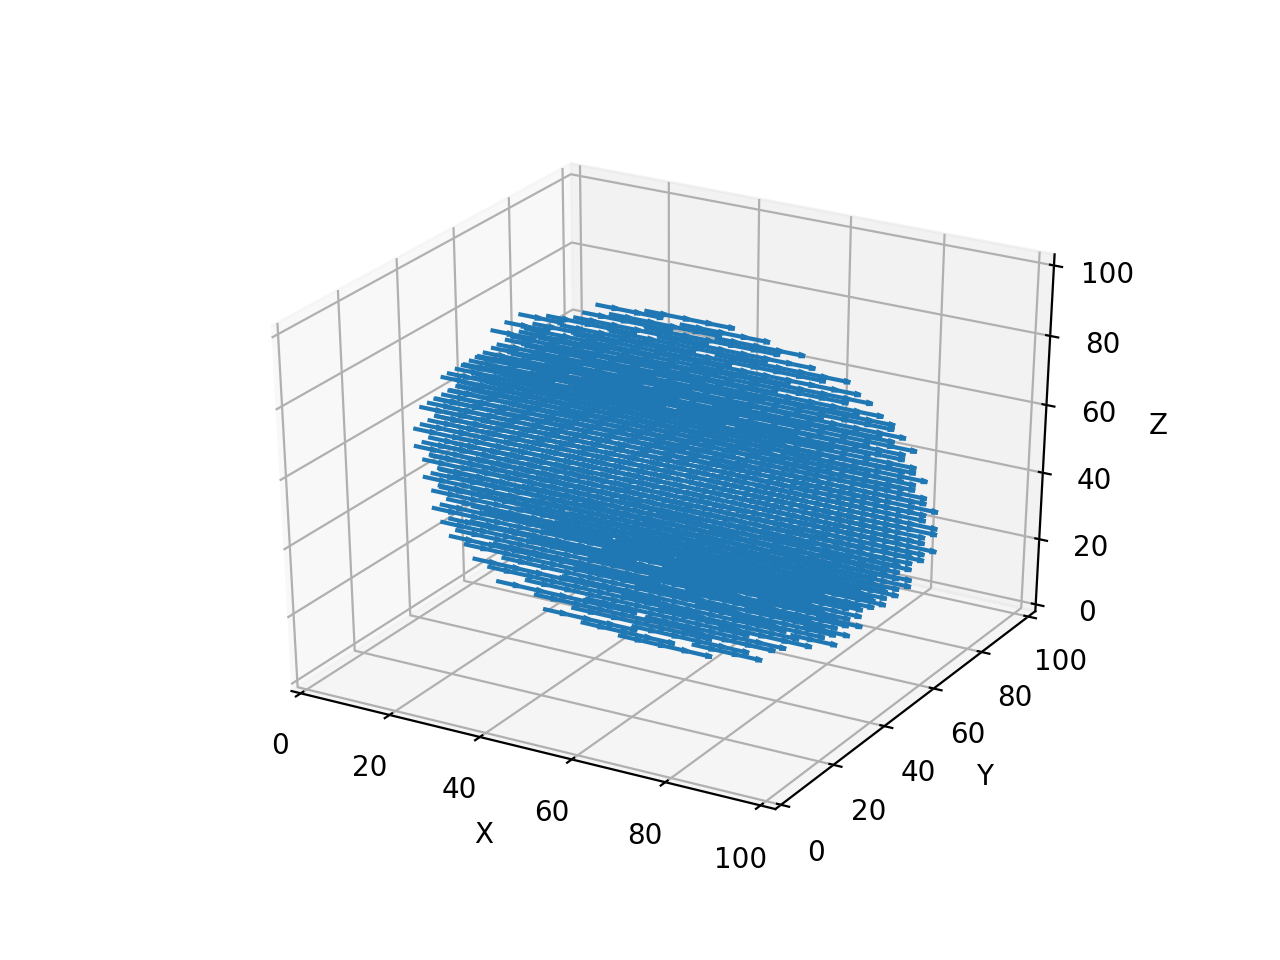

     C3D: get_emis(5) interpolated using numpy-method


Text(0.5, 0, 'Z')

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
skip = 5
counter = range(0, dim, skip)
x,y,z = np.meshgrid(counter, counter, counter)
ax.quiver(x, y, z, m3d.get_emis('O__2_372603A')[::skip, ::skip, ::skip], 0, 0, length=5, normalize=True)
ax.set_xlim(0, dim)
ax.set_ylim(0, dim)
ax.set_zlim(0, dim)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.plot()

# More Plots

In [19]:
m3d.get_profile_list()

def plot_profiles(m3d, x_pos, y_pos):
    plt.plot(m3d.vel_tab,m3d.get_profile('O__2_372603A', axis=proj_axis)[:,x_pos,y_pos], label = r'[OII]$ \lambda$3726')
    plt.plot(m3d.vel_tab,m3d.get_profile('O__2_372881A', axis=proj_axis)[:,x_pos,y_pos], label = r'[OII]$ \lambda$3729')
    plt.legend()

In [20]:
def other_plots(m3d, proj_axis):
    
    plt.subplot(221)
    plt.imshow(m3d.get_emis('O__2_372603A').sum(axis = proj_axis)*m3d.cub_coord.cell_size)
#     plt.xlim(40, 60)
#     plt.ylim(40, 60)
    plt.title('[OII] 3726')
    plt.colorbar()
    
    plt.subplot(222)
    plt.imshow(m3d.get_emis('O__2_372881A').sum(axis = proj_axis)*m3d.cub_coord.cell_size)
    plt.title('[OII] 3729')
#     plt.xlim(40, 60)
#     plt.ylim(40, 60)
    plt.colorbar()
    
    plt.subplot(223)
    plt.imshow(m3d.get_emis('O__2_372881A').sum(axis = proj_axis)/m3d.get_emis('O__2_372603A').sum(axis = proj_axis))
    plt.title('[OII] 3729 / [OII] 3726')
    plt.colorbar()
    
    plt.subplot(224)
    velocity = m3d.vel_tab[np.argmax(m3d.get_profile('O__2_372603A', axis = proj_axis), axis = 0)]
    velocity[velocity == np.min(m3d.vel_tab)] = np.nan
    plt.imshow(velocity)
    plt.title('[OII] 3726 Velocity')
#     plt.xlim(40, 60)
#     plt.ylim(40, 60)
    plt.colorbar()

<IPython.core.display.Javascript object>


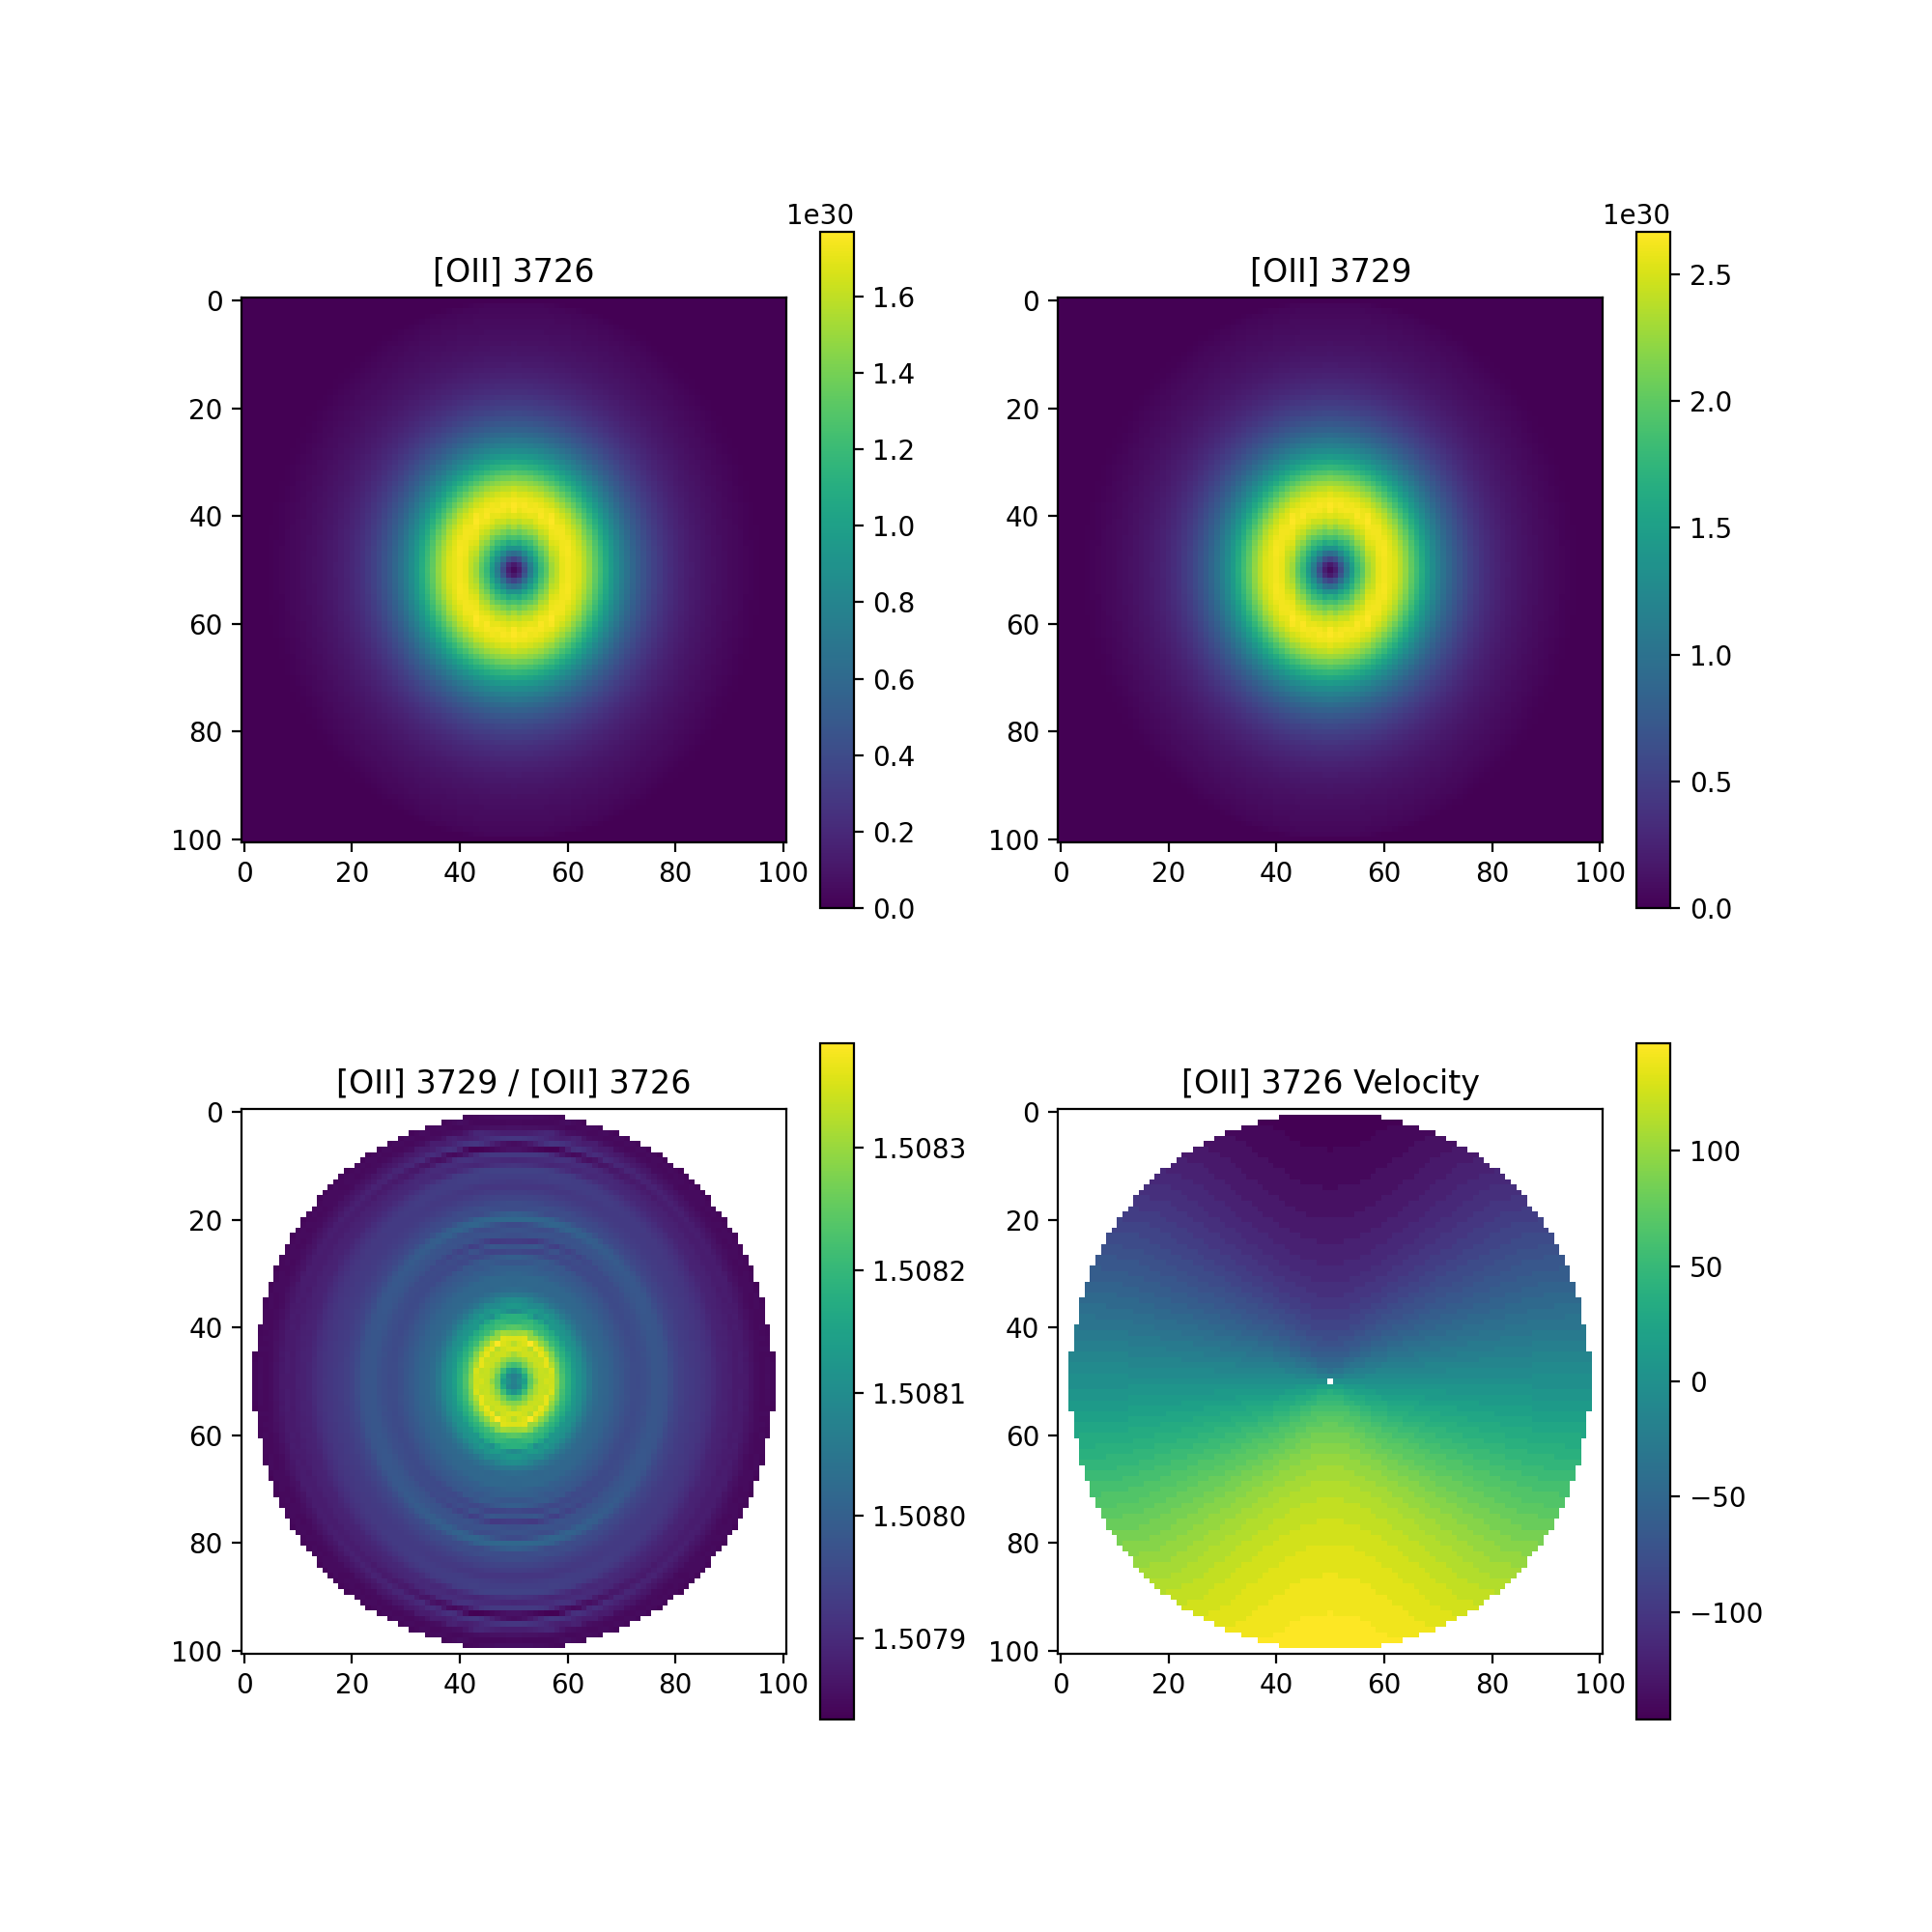

     C3D: get_emis(6) interpolated using numpy-method
     C3D: te interpolated using numpy-method


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


     C3D: line O__2_372603A : profile computed on axis 2


In [21]:
plt.figure(figsize=(10,10))
other_plots(m3d, proj_axis)